# emcee: PHYS265 Final Project

In this project, we introduce the emcee package, and in particular its usage in fitting a model to data when you don't trust uncertainties/the data is noisy. First, let's generate some noisy data for a linear fit with prescribed parameters:

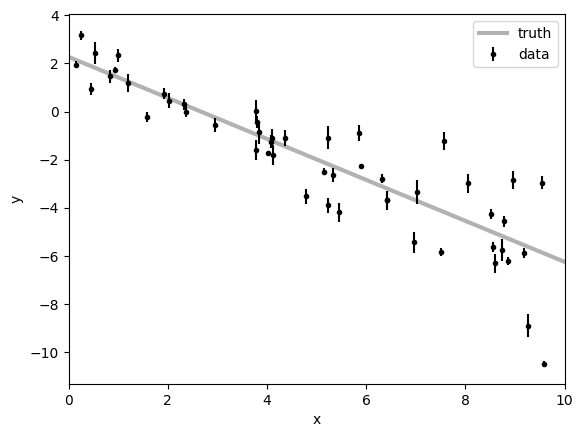

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(256)

# Choose the "true" parameters.
m_true = -0.8520
b_true = 2.275
f_true = 0.421

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.4 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label = "data")
x0 = np.linspace(0, 10, 500)
ax.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label = "truth")
ax.set_xlim(0, 10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend();

As can be seen from the plot, the errorbars are quite small compared to the spread of the data. This indicates that the error has been underestimated. Clearly, a least-squares method wouldn't give a great fit to the data, especially at the tail end of the distribution. We could fix this by using maximum likelihood estimation. The least-squares method assumes that our errors are correct, independent, and Gaussian (which we know is not true). To do maximum likelihood estimation, one numerically optimizes the likelihood function (equivalent to optimizing the log of the likelihood function).

In [2]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -0.884
b = 2.266
f = 0.404


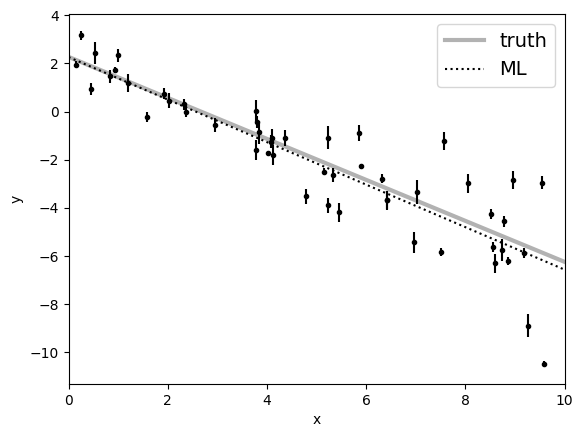

In [3]:
from scipy.optimize import minimize

np.random.seed(45)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
ax.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
ax.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
ax.legend(fontsize=14)
ax.set_xlim(0, 10)
ax.set_xlabel("x")
ax.set_ylabel("y");

This is a great fit; however, this method doesn't give information on how to propagate uncertainties on the parameters of the model (m,b, and f). For that, we need to use Markov-chain Monte Carlo (through emcee), since it generates a posterior distribution of parameter probabilities (which allows us to estimate uncertainties from the marginal probability distributions). We first need a prior distribution of parameters, encompassing all information we have (from experiment, other analyses, etc).

In [4]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

This then factors into our probability distribution as follows:

In [5]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Now we just need to generate the walkers to explore the probability distribution. We'll start them out distributed in a small Gaussian ball outside of the maximum likelihood, which we determined earlier.

In [6]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000);

The following plot just shows how the walkers explore the distribution, with the x-axis indicating the number of steps. Notice how they start out at the maximum value, but quickly start exploring a large part of the distribution around this maximum value. This step is important; if your walkers look like they're getting stuck in local minima, then your posterior distribution won't be accurate. Furthermore, if you try to calculate autocorrelation times (explained in the next step), you may run into errors.

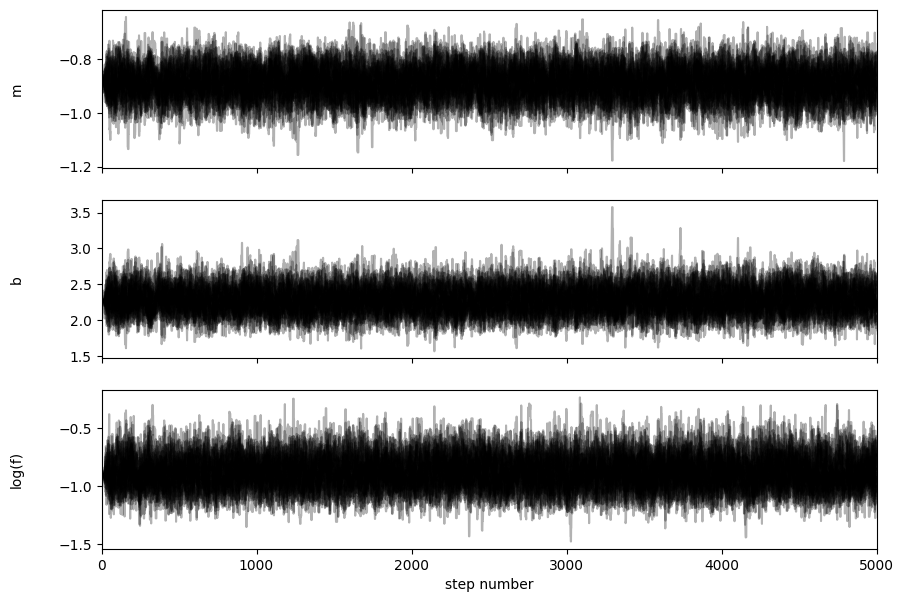

In [7]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

The time taken for the walkers to "forget" where they were initialized is called the autocorrelation time; it is essentially how many steps the walkers take to "burn-in" and go from the small Gaussian ball to a larger range around the distribution. This is important, since we don't want to bias samples from around the start location. Since we want to sample uniformly around our maximum, we want to cut out the bias by ensuring our walkers are burned in *before* we start taking samples.

In [8]:
tau = sampler.get_autocorr_time()
print(tau)

[39.87545149 38.21719609 35.07541795]


Now that we've determined our autocorrelation time (about 40 steps), we can generate our samples. We'll cut the first 100 samples to ensure our walkers are fully burned in once we start sampling, thin by 15 samples (half the autocorrelation time) to again ensure that our samples are distributed more uniformly (and to cut the total number of samples), and flatten out the chain of samples (again, making the distribution of samples more uniform).

In [9]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)


(10432, 3)


It is now time for us to visualize our output posterior probability distributions. We can do this by making a corner plot of the samples, giving us 2D and 1D projections of the probability distribution. The diagonal plots give the marginal posterior probability distribution for each parameter individually; the width of this distribution gives the uncertainty in the parameter. The off-diagonal plots show the marginal joint probability density function for a pair of parameters. The shape (elongated vs circular) tells you how the parameters are correlated (for example, m and b seem to be negatively correlated since the shape of their joint pdf is an ellipse slanted downwards). The strength of the correlation indicates a higher magnitude of covariance, while the sign of the correlation gives the sign of the covariance. Each contour represents a confidence interval for the true parameter values. The blue line(s) represent the true value(s).

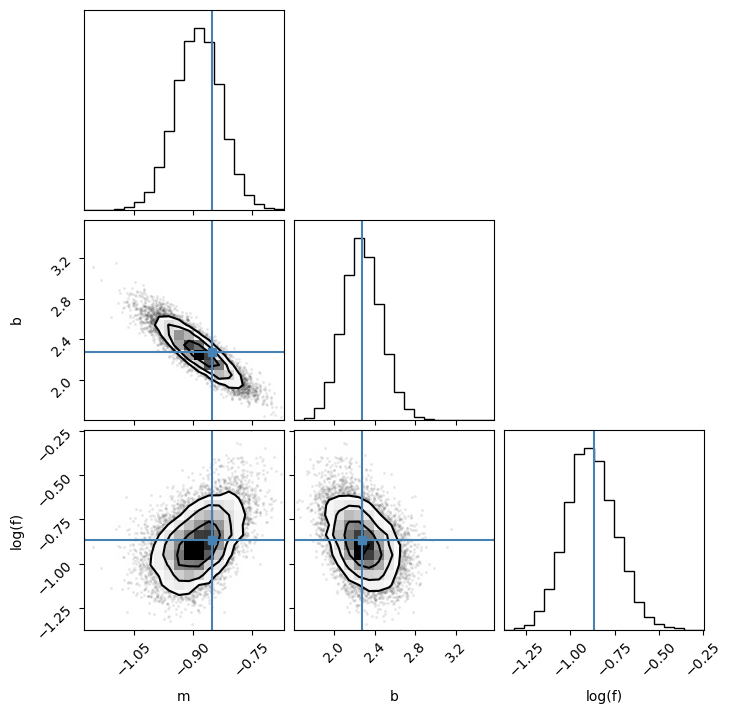

In [10]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);
plt.savefig("Figure2.png")

Finally, we can plot our samples against our data (and the true model) to see how they line up. Clearly, we are exploring the regior around the "true" value, meaning that our uncertainty estimates should be accurate.

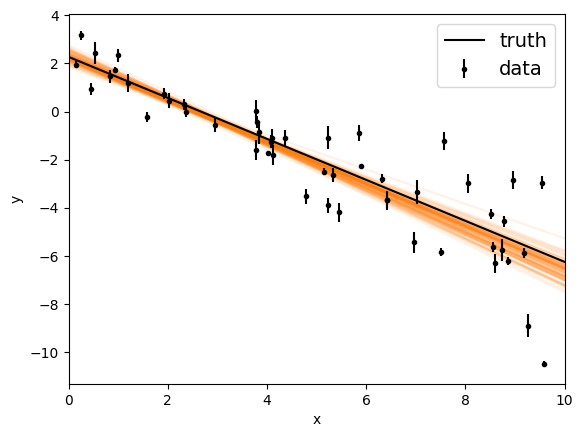

In [11]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label = "data")
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");
plt.savefig("Figure1.png")

The plot above shows samples from the parameter distribution, inserted into our model function, plotted in orange. The black line represents the true model, and the black dots represent data. As desired, our distribution values are clustered around the true value.

Finally, we can determine our fit parameters and uncertainties by looking at the 16th, 50th, and 84th percentiles of the sample data for each parameter (i.e. the 50th percentile is the data value, and the difference between it and the 16th and 84th percentiles determine the two uncertainties).

In [12]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>